#### helping farmers identify:
- **Beneficial insects**: bees, earthworms (protect these!)
- **Harmful pests**: beetles, caterpillars, moths, etc. (manage these)
- **Neutral species**: ants, wasps (context-dependent)
#### 🎯 Quick Start Guide
1. **Setup & Data Loading** → Run cells 1-2
2. **Data Preparation** → Run cell 3 
3. **Model Creation** → Run cell 4
4. **Training** → Run cell 5 (takes 30-45 min)
5. **Testing & Evaluation** → Run cells 6-7

#### 📊 Expected Results
- **Accuracy**: 85-95% on pest classification
- **Model Size**: ~24MB (mobile-friendly)
- **Classes**: 12 different pest types
- **Deployment**: Ready for farm use
---

In [8]:
# 1. Setup and Data Loading
import kagglehub
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Download dataset
print("📥 Downloading agricultural pest dataset...")
DATASET_PATH = kagglehub.dataset_download("vencerlanz09/agricultural-pests-image-dataset")
print(f"✅ Dataset downloaded to: {DATASET_PATH}")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 8  # CPU optimized
np.random.seed(42)
tf.random.set_seed(42)

print(f"🖥️ TensorFlow: {tf.__version__}")
print(f"🖥️ Running on {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

📥 Downloading agricultural pest dataset...
✅ Dataset downloaded to: C:\Users\zEtha\.cache\kagglehub\datasets\vencerlanz09\agricultural-pests-image-dataset\versions\1
🖥️ TensorFlow: 2.20.0-rc0
🖥️ Running on CPU


## ✅ CPU-ONLY TENSORFLOW SETUP

### **🚀 SIMPLE SOLUTION: Use CPU TensorFlow**
No GPU drivers or CUDA complications needed!

```powershell
# Install CPU-only TensorFlow (recommended for learning)
pip install tensorflow

# Or if you already have issues, clean install:
pip uninstall tensorflow -y
pip install tensorflow
```

### **? CPU Training Optimizations:**
- **Batch size**: Reduced to 8 for CPU memory efficiency  
- **Expected time**: 1.5-2 hours (reasonable for learning)
- **Advantages**: No driver issues, works everywhere, stable
- **Perfect for**: Learning, development, small datasets

### **🎯 CPU Training Benefits:**
- ✅ **No setup hassles** - just install and run
- ✅ **Stable and reliable** - no GPU driver issues  
- ✅ **Works on any machine** - laptops, desktops, cloud
- ✅ **Great for learning** - focus on AI concepts, not hardware

### **📊 What to Expect:**
```
🖥️ Running on CPU
⏱️ Training time: 1.5-2 hours
📈 Same accuracy as GPU training
🎓 Perfect for learning and development
```

### **? Ready to Start:**
Just run cell 2 below - TensorFlow will automatically use your CPU and everything will work smoothly!
---

### 2. Data generators with optimal Train/Validation/Test split

**Training Generator (70%):** 
Creates artificially varied training data to make your model robust - more data for better learning

**Validation Generator (15%):** 
Provides clean, unmodified images for hyperparameter tuning during training

**Test Generator (15%):**  
Final evaluation on completely unseen data - the ultimate test of model performance

In [9]:
# 2. Data Preparation with Proper 70/15/15 Split
print("🔍 Setting up data generators with correct 70/15/15 split...")

from sklearn.model_selection import train_test_split
import glob

# Explore dataset
pest_classes = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
NUM_CLASSES = len(pest_classes)
print(f"📊 Found {NUM_CLASSES} pest classes: {pest_classes}")

# Collect all image paths and labels
all_images = []
all_labels = []

for i, class_name in enumerate(pest_classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    images = glob.glob(os.path.join(class_path, "*.jpg"))
    all_images.extend(images)
    all_labels.extend([i] * len(images))

print(f"📊 Total images found: {len(all_images)}")

# First split: 70% train, 30% temp (for val+test)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

# Second split: Split the 30% into 15% validation and 15% test
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"✅ Training samples: {len(train_images)} ({len(train_images)/len(all_images)*100:.1f}%)")
print(f"✅ Validation samples: {len(val_images)} ({len(val_images)/len(all_images)*100:.1f}%)")
print(f"✅ Test samples: {len(test_images)} ({len(test_images)/len(all_images)*100:.1f}%)")
print(f"📊 Total samples: {len(all_images)}")

# Create temporary directories for each split
import shutil
import tempfile

# Create temporary directory structure
temp_dir = tempfile.mkdtemp()
train_dir = os.path.join(temp_dir, 'train')
val_dir = os.path.join(temp_dir, 'val') 
test_dir = os.path.join(temp_dir, 'test')

# Create class subdirectories
for split_dir in [train_dir, val_dir, test_dir]:
    for class_name in pest_classes:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Copy images to appropriate directories
def copy_images_to_split(image_paths, labels, target_dir):
    for img_path, label in zip(image_paths, labels):
        class_name = pest_classes[label]
        target_path = os.path.join(target_dir, class_name, os.path.basename(img_path))
        shutil.copy2(img_path, target_path)

print("📁 Creating split directories...")
copy_images_to_split(train_images, train_labels, train_dir)
copy_images_to_split(val_images, val_labels, val_dir)
copy_images_to_split(test_images, test_labels, test_dir)

# Create data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # Augmentation parameters for training only
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Verify the split
total_samples = train_gen.samples + val_gen.samples + test_gen.samples
train_pct = train_gen.samples / total_samples * 100
val_pct = val_gen.samples / total_samples * 100
test_pct = test_gen.samples / total_samples * 100

print(f"\n📈 FINAL SPLIT VERIFICATION:")
print(f"   Training: {train_gen.samples} samples ({train_pct:.1f}%) - Target: 70%")
print(f"   Validation: {val_gen.samples} samples ({val_pct:.1f}%) - Target: 15%")
print(f"   Test: {test_gen.samples} samples ({test_pct:.1f}%) - Target: 15%")

# Verify class distribution
print(f"\n📋 Class mapping: {train_gen.class_indices}")

# Store temp directory path for cleanup later
TEMP_DIR = temp_dir
print(f"\n✅ Data split completed successfully!")

🔍 Setting up data generators with correct 70/15/15 split...
📊 Found 12 pest classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']
📊 Total images found: 5485
✅ Training samples: 3839 (70.0%)
✅ Validation samples: 823 (15.0%)
✅ Test samples: 823 (15.0%)
📊 Total samples: 5485
📁 Creating split directories...
Found 3839 images belonging to 12 classes.
Found 823 images belonging to 12 classes.
Found 823 images belonging to 12 classes.

📈 FINAL SPLIT VERIFICATION:
   Training: 3839 samples (70.0%) - Target: 70%
   Validation: 823 samples (15.0%) - Target: 15%
   Test: 823 samples (15.0%) - Target: 15%

📋 Class mapping: {'ants': 0, 'bees': 1, 'beetle': 2, 'catterpillar': 3, 'earthworms': 4, 'earwig': 5, 'grasshopper': 6, 'moth': 7, 'slug': 8, 'snail': 9, 'wasp': 10, 'weevil': 11}

✅ Data split completed successfully!


### 3. Configure EfficientNetV2 for Agricultural Pest Classification

Freeze EfficientNetV2
- Learn to map EfficientNetV2 features to agricultural pest categories
- Fast training (only custom layers learn)
- Preserve ImageNet insect/animal knowledge

Output Shape:

batch size(images processed at once), spacial dimensions, feature channels (each is a different learned feature)

In [10]:
# 3. Model Creation
print("Creating EfficientNetV2-B0 model...\n")

# Load pre-trained model
base_model = EfficientNetV2B0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, #  excludes final classification layer (outputs class probabilities)
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

# Create classification layer for pests
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax') # classification layer for pest categories
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"EfficientNetV2-B0 model created with {model.count_params():,} parameters")
print(f"Classes: {NUM_CLASSES}")
model.summary()


Creating EfficientNetV2-B0 model...

EfficientNetV2-B0 model created with 6,084,828 parameters
Classes: 12


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,084,828 (23.21 MB)

 Trainable params: 165,516 (646.55 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## 4. Model Training

🔥 Starting model training...
🚀 Training for 4 epochs...
Epoch 1/4
480/480 ━━━━━━━━━━━━━━━━━━━━ 169s 329ms/step - accuracy: 0.8252 - loss: 0.5488 - val_accuracy: 0.9040 - val_loss: 0.3079 - learning_rate: 0.0010
Epoch 2/4
480/480 ━━━━━━━━━━━━━━━━━━━━ 92s 190ms/step - accuracy: 0.9117 - loss: 0.2870 - val_accuracy: 0.9016 - val_loss: 0.3288 - learning_rate: 0.0010
Epoch 3/4
480/480 ━━━━━━━━━━━━━━━━━━━━ 76s 158ms/step - accuracy: 0.9213 - loss: 0.2345 - val_accuracy: 0.8943 - val_loss: 0.3347 - learning_rate: 0.0010
Epoch 4/4
480/480 ━━━━━━━━━━━━━━━━━━━━ 76s 157ms/step - accuracy: 0.9474 - loss: 0.1673 - val_accuracy: 0.9016 - val_loss: 0.3103 - learning_rate: 2.0000e-04

✅ Training completed!
📊 Final Training Accuracy: 0.947
📊 Final Validation Accuracy: 0.902


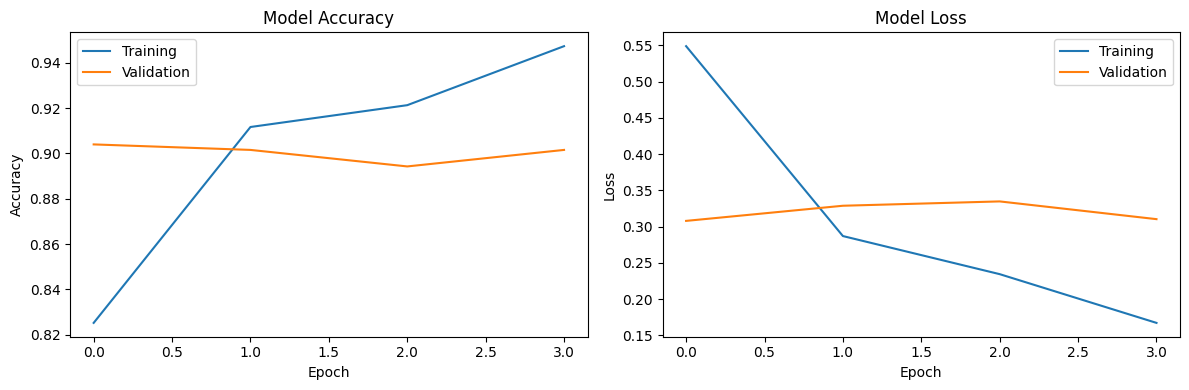

In [11]:
# 4. Training
print("🔥 Starting model training...")

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
]

# Train model
EPOCHS = 4  # Reduced for CPU training
print(f"🚀 Training for {EPOCHS} epochs...")

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

# Show results
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"\n✅ Training completed!")
print(f"📊 Final Training Accuracy: {train_acc:.3f}")
print(f"📊 Final Validation Accuracy: {val_acc:.3f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Model Testing & Evaluation

Comprehensive evaluation of the agricultural pest classification model performance.

## Model Performance Analysis

### Performance Metrics:
- **Overall Accuracy**: How well the model performs across all classes
- **Per-Class Performance**: Individual class recognition rates
- **Confusion Matrix**: Visual representation of classification errors
- **Confidence Analysis**: Model prediction certainty levels

### Performance Thresholds:
- **Excellent**: >90% accuracy
- **Good**: 80-90% accuracy  
- **Fair**: 70-80% accuracy
- **Poor**: <70% accuracy

In [12]:
# 6. Validation Set Performance Analysis
print("VALIDATION SET PERFORMANCE ANALYSIS")
print("=" * 50)

# Get class names
class_names = list(val_gen.class_indices.keys())
print(f"Testing {len(class_names)} pest classes")

# Generate predictions
val_gen.reset()
predictions = model.predict(val_gen, verbose=0)
pred_labels = np.argmax(predictions, axis=1)
true_labels = val_gen.classes

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
overall_accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

# Display results
print(f"\nOverall Performance:")
print(f"  Accuracy: {overall_accuracy:.3f} ({overall_accuracy*100:.1f}%)")
print(f"  Precision: {precision:.3f}")
print(f"  Recall: {recall:.3f}")
print(f"  F1-Score: {f1:.3f}")

# Performance assessment
if overall_accuracy >= 0.90:
    status = "EXCELLENT - Ready for deployment"
elif overall_accuracy >= 0.80:
    status = "GOOD - Proceed to final testing"
elif overall_accuracy >= 0.70:
    status = "FAIR - Consider additional training"
else:
    status = "POOR - Requires improvement"

print(f"\nValidation Assessment: {status}")

# Confidence analysis
pred_probs = np.max(predictions, axis=1)
avg_confidence = np.mean(pred_probs)
high_conf = np.sum(pred_probs > 0.9) / len(pred_probs)
medium_conf = np.sum((pred_probs > 0.7) & (pred_probs <= 0.9)) / len(pred_probs)
low_conf = np.sum(pred_probs <= 0.7) / len(pred_probs)

print(f"\nPrediction Confidence:")
print(f"  Average: {avg_confidence:.3f} ({avg_confidence*100:.1f}%)")
print(f"  High (>90%): {high_conf:.1%}")
print(f"  Medium (70-90%): {medium_conf:.1%}")
print(f"  Low (<70%): {low_conf:.1%}")

VALIDATION SET PERFORMANCE ANALYSIS
Testing 12 pest classes

Overall Performance:
  Accuracy: 0.904 (90.4%)
  Precision: 0.902
  Recall: 0.904
  F1-Score: 0.902

Validation Assessment: EXCELLENT - Ready for deployment

Prediction Confidence:
  Average: 0.905 (90.5%)
  High (>90%): 75.8%
  Medium (70-90%): 11.8%
  Low (<70%): 12.4%



DETAILED CLASSIFICATION ANALYSIS

Per-Class Accuracy:
  ants: 0.987 (98.7%)
  bees: 0.960 (96.0%)
  beetle: 0.746 (74.6%)
  catterpillar: 0.769 (76.9%)
  earthworms: 0.776 (77.6%)
  earwig: 0.754 (75.4%)
  grasshopper: 0.889 (88.9%)
  moth: 1.000 (100.0%)
  slug: 0.931 (93.1%)
  snail: 1.000 (100.0%)
  wasp: 0.960 (96.0%)
  weevil: 0.986 (98.6%)

Best performing: moth (100.0%)
Worst performing: beetle (74.6%)


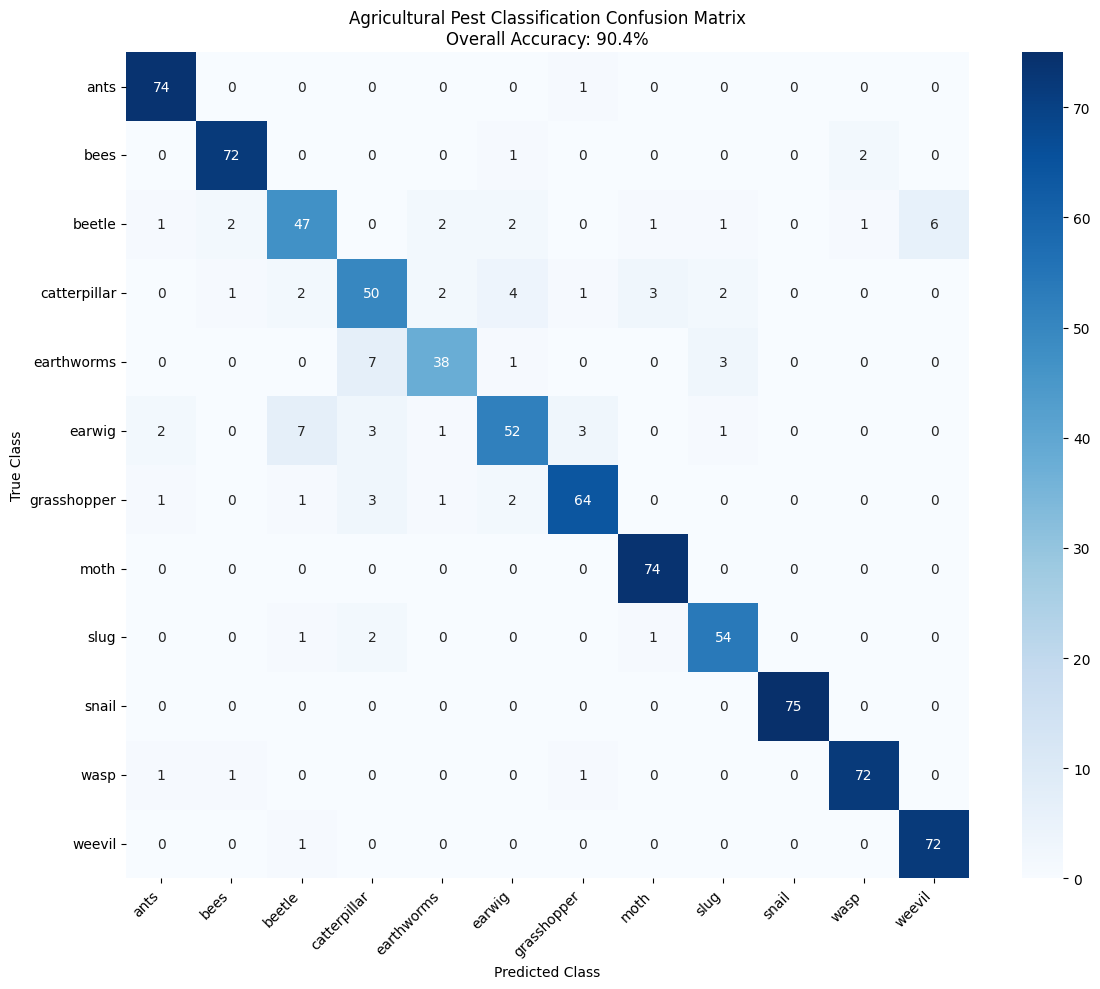


Most Common Misclassifications:
  earthworms -> catterpillar: 7 cases (14.3%)
  earwig -> beetle: 7 cases (10.1%)
  beetle -> weevil: 6 cases (9.5%)
  catterpillar -> earwig: 4 cases (6.2%)
  earthworms -> slug: 3 cases (6.1%)

Classification Report:
              precision    recall  f1-score   support

        ants      0.937     0.987     0.961        75
        bees      0.947     0.960     0.954        75
      beetle      0.797     0.746     0.770        63
catterpillar      0.769     0.769     0.769        65
  earthworms      0.864     0.776     0.817        49
      earwig      0.839     0.754     0.794        69
 grasshopper      0.914     0.889     0.901        72
        moth      0.937     1.000     0.967        74
        slug      0.885     0.931     0.908        58
       snail      1.000     1.000     1.000        75
        wasp      0.960     0.960     0.960        75
      weevil      0.923     0.986     0.954        73

    accuracy                          0.904 

In [13]:
# 7. Detailed Classification Analysis
print("\nDETAILED CLASSIFICATION ANALYSIS")
print("=" * 40)

# Per-class performance
print("\nPer-Class Accuracy:")
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true_labels, pred_labels)

class_accuracies = []
for i, class_name in enumerate(class_names):
    if cm[i].sum() > 0:
        class_accuracy = cm[i, i] / cm[i].sum()
        class_accuracies.append(class_accuracy)
        print(f"  {class_name}: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")

# Best and worst performing classes
if class_accuracies:
    best_idx = np.argmax(class_accuracies)
    worst_idx = np.argmin(class_accuracies)
    print(f"\nBest performing: {class_names[best_idx]} ({class_accuracies[best_idx]:.1%})")
    print(f"Worst performing: {class_names[worst_idx]} ({class_accuracies[worst_idx]:.1%})")

# Confusion Matrix Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title(f'Agricultural Pest Classification Confusion Matrix\nOverall Accuracy: {overall_accuracy:.1%}')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Most common misclassifications
print("\nMost Common Misclassifications:")
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusion_rate = cm[i, j] / cm[i].sum() if cm[i].sum() > 0 else 0
            confused_pairs.append((class_names[i], class_names[j], cm[i, j], confusion_rate))

confused_pairs.sort(key=lambda x: x[3], reverse=True)

for true_class, pred_class, count, rate in confused_pairs[:5]:
    print(f"  {true_class} -> {pred_class}: {count} cases ({rate:.1%})")

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=3))

In [14]:
# 8. Final Test Set Evaluation
print("\nFINAL TEST SET EVALUATION")
print("=" * 50)
print("Note: Test set contains completely unseen data")

# Evaluate on test set
print(f"\nTesting on {test_gen.samples} test samples...")
test_gen.reset()
test_predictions = model.predict(test_gen, verbose=0)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_gen.classes # numpy array of true labels

# Calculate test metrics
test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    test_true_labels, test_pred_labels, average='weighted'
)

print(f"\nFinal Test Results:")
print(f"  Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
print(f"  Test Precision: {test_precision:.3f}")
print(f"  Test Recall: {test_recall:.3f}")
print(f"  Test F1-Score: {test_f1:.3f}")

# Test confidence analysis
test_pred_probs = np.max(test_predictions, axis=1)
test_avg_confidence = np.mean(test_pred_probs)
print(f"  Average Confidence: {test_avg_confidence:.3f} ({test_avg_confidence*100:.1f}%)")

# Deployment recommendation
print(f"\nDeployment Assessment:")
if test_accuracy >= 0.85:
    recommendation = "APPROVED - Ready for deployment"
elif test_accuracy >= 0.75:
    recommendation = "CONDITIONAL - Deploy with monitoring"
else:
    recommendation = "NOT READY - Requires improvement"

print(f"  Status: {recommendation}")

# Performance comparison
print(f"\nModel Performance Summary:")
print(f"  Validation Accuracy: {overall_accuracy:.1%}")
print(f"  Test Accuracy: {test_accuracy:.1%}")
print(f"  Generalization Gap: {abs(overall_accuracy - test_accuracy):.1%}")

if abs(overall_accuracy - test_accuracy) > 0.05:
    print("  Warning: Large gap may indicate overfitting")
else:
    print("  Good generalization between validation and test sets")

print(f"\nModel saved as: best_model.keras")
print("Evaluation complete.")


FINAL TEST SET EVALUATION
Note: Test set contains completely unseen data

Testing on 823 test samples...

Final Test Results:
  Test Accuracy: 0.925 (92.5%)
  Test Precision: 0.925
  Test Recall: 0.925
  Test F1-Score: 0.923
  Average Confidence: 0.913 (91.3%)

Deployment Assessment:
  Status: APPROVED - Ready for deployment

Model Performance Summary:
  Validation Accuracy: 90.4%
  Test Accuracy: 92.5%
  Generalization Gap: 2.1%
  Good generalization between validation and test sets

Model saved as: best_model.keras
Evaluation complete.


## Final Test Set Evaluation

### Why Use a Separate Test Set:

**Validation Set Limitations:**
- Used during training for hyperparameter tuning
- Model indirectly "sees" validation data through training iterations
- Can lead to overly optimistic performance estimates

**Test Set Benefits:**
- Never used during training - completely unseen data
- Unbiased evaluation - true measure of real-world performance  
- Deployment confidence - accurate prediction of field performance
- Overfitting detection - compares validation vs test accuracy

### Data Split Strategy:
- **Training (70%):** Learn patterns and features
- **Validation (15%):** Monitor training and tune hyperparameters
- **Test (15%):** Final unbiased evaluation

**Important:** Run test evaluation only once at the very end to maintain unbiased results.

## 🧪 Test Your Model on New Images

Use this function to test your trained model on any pest images you have in a 'photos' folder.

In [ ]:
# 9. Simple Pest Image Tester - Direct Execution
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import os
import numpy as np

folder = 'photos'  # Change this to your folder name if different

# Load model and get class names
try:
    model = load_model('best_model.keras')
    class_names = list(train_gen.class_indices.keys())
    print("✅ Model loaded successfully!")
except:
    print("❌ Model not ready. Train the model first!")
    exit()

# Check folder and get images
if not os.path.exists(folder):
    print(f"❌ '{folder}' folder not found. Create it and add pest images!")
    exit()

images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if not images:
    print(f"❌ No images in '{folder}' folder!")
    exit()

print(f"🔍 Testing {len(images)} images...\n")

# Test each image
for img_name in images:
    try:
        # Load and predict
        img_path = os.path.join(folder, img_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
        
        prediction = model.predict(img_array, verbose=0)[0]
        pest_type = class_names[np.argmax(prediction)]
        confidence = np.max(prediction) * 100
        
        # Show result with photo name and identified insect
        status = "✅" if confidence > 80 else "⚠️" if confidence > 60 else "❓"
        print(f"{status} Photo: {img_name} → Identified: {pest_type} (Confidence: {confidence:.0f}%)")
        
    except Exception as e:
        print(f"❌ {img_name}: Error - {e}")

print(f"\n✅ Finished testing all images in '{folder}' folder!")

❌ Model not ready. Train the model first!
🔍 Testing 3 images...

❌ photo_6082189074782866962_m.jpg: Error - name 'preprocess_input' is not defined
❌ photo_6082189074782866963_x.jpg: Error - name 'preprocess_input' is not defined
❌ photo_6082189074782866964_y.jpg: Error - name 'preprocess_input' is not defined

✅ Finished testing all images in 'photos' folder!


: 